In [19]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

from config import Config, MulticlassConfig
from preprocessing import (
    build_vocab, save_vocab, load_vocab,
    build_scaler, save_scaler, load_scaler,
    build_label_encoder, save_label_encoder, load_label_encoder,
    MalwareDataset
)
from model import BiLSTM
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings('ignore')

In [20]:
mode = input("Pilih mode (1=binary, 2=multiclass): ").strip()

if mode == "1":
    cfg = Config()
    model_name = "binary_model.pth"
    data_files = ["fitur_benign.csv", "fitur_malware.csv"]
    file_label_map = {
        "fitur_benign.csv": 0,
        "fitur_malware.csv": 1
    }
    print("Mode: binary")
elif mode == "2":
    cfg = MulticlassConfig()
    model_name = "multiclass_model.pth"
    data_files = [
        "fitur_Adware.csv",
        "fitur_coinminer.csv",
        "fitur_Keylogger.csv",
        "fitur_Ransomware.csv",
        "fitur_Trojan.csv",
        "fitur_Dropper.csv",
        "fitur_RAT.csv",
        "fitur_BOTNET.csv",
        "fitur_Other.csv",
        "fitur_Stealer.csv",
        "fitur_Crypto.csv"
    ]
    file_label_map = {
        fname: os.path.splitext(fname)[0].split("_")[1].lower()
        for fname in data_files
    }
    print("Mode: multiclass")

max_len = cfg.max_length
batch_size = cfg.batch_size
epochs = cfg.epochs
lr = cfg.learning_rate


Mode: multiclass


In [21]:
ARTIFACT_DIR = "artifacts"
VOCAB_PATH = os.path.join(ARTIFACT_DIR, "vocab.pkl")
SCALER_PATH = os.path.join(ARTIFACT_DIR, "scaler.pkl")
LABEL_ENCODER_PATH = os.path.join(ARTIFACT_DIR, "label_encoder.pkl")
MODEL_PATH = os.path.join(ARTIFACT_DIR, model_name)

label
crypto        163
other         130
dropper       120
rat           120
trojan        119
botnet        113
keylogger     107
ransomware    104
adware         99
Name: count, dtype: int64


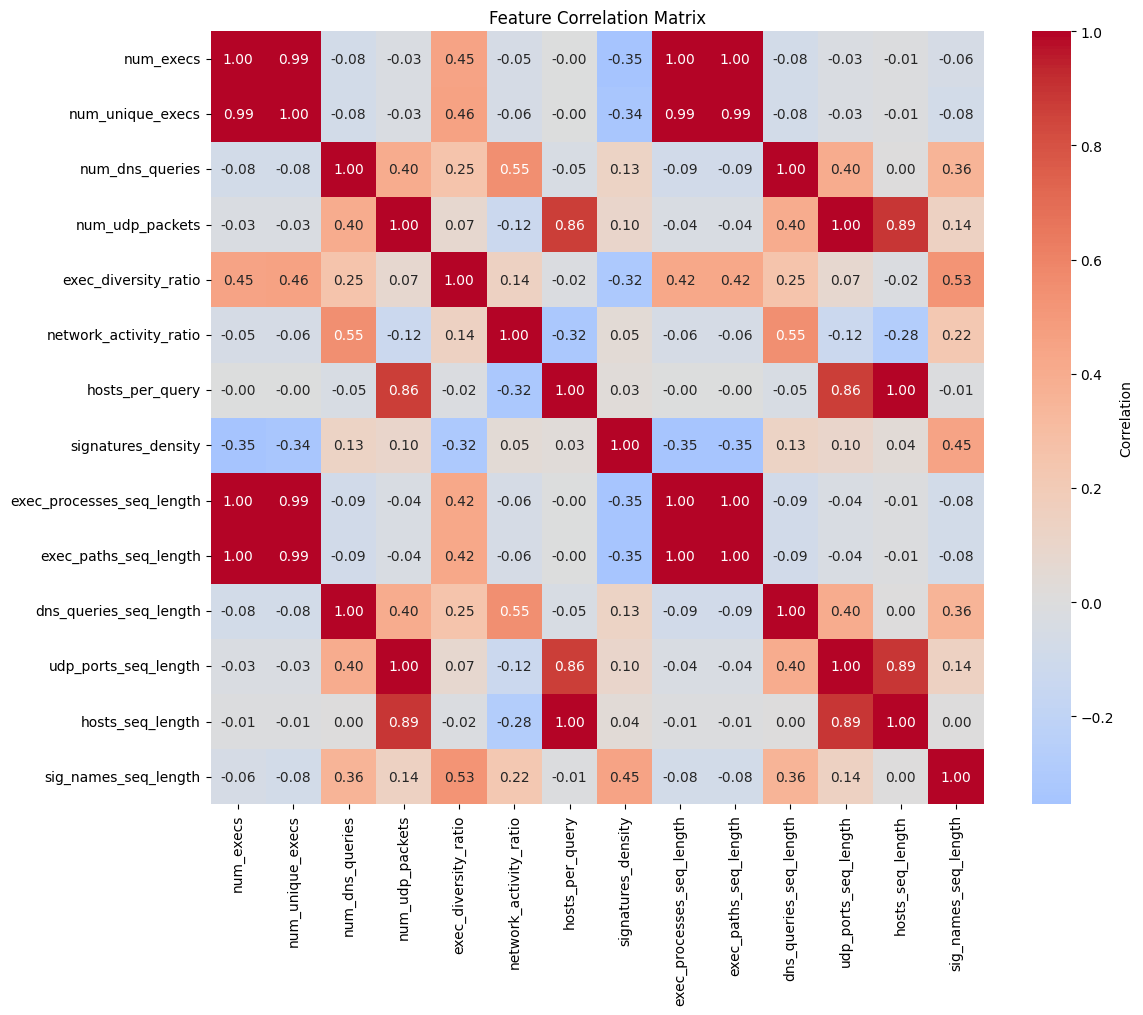


Highly correlated feature pairs (>0.7):
num_execs <-> num_unique_execs: 0.990
num_execs <-> exec_processes_seq_length: 0.999
num_execs <-> exec_paths_seq_length: 0.999
num_unique_execs <-> exec_processes_seq_length: 0.990
num_unique_execs <-> exec_paths_seq_length: 0.990
num_dns_queries <-> dns_queries_seq_length: 1.000
num_udp_packets <-> hosts_per_query: 0.865
num_udp_packets <-> udp_ports_seq_length: 1.000
num_udp_packets <-> hosts_seq_length: 0.894
hosts_per_query <-> udp_ports_seq_length: 0.865
hosts_per_query <-> hosts_seq_length: 0.995
exec_processes_seq_length <-> exec_paths_seq_length: 1.000
udp_ports_seq_length <-> hosts_seq_length: 0.894

Analyzed 14 features:
- Original numeric: ['num_execs', 'num_unique_execs', 'num_dns_queries', 'num_udp_packets', 'exec_diversity_ratio', 'network_activity_ratio', 'hosts_per_query', 'signatures_density']
- Sequence lengths: ['exec_processes_seq_length', 'exec_paths_seq_length', 'dns_queries_seq_length', 'udp_ports_seq_length', 'hosts_seq_

In [22]:
df_list = []
for fname in data_files:
    df_i = pd.read_csv(os.path.join(fname))
    df_i["label"] = file_label_map[fname]
    df_list.append(df_i)
df = pd.concat(df_list, ignore_index=True)

if mode == "2":
    merge_mapping = {
        "coinminer":"crypto",
        "stealer": "other",
    }

    df['label'] = df['label'].replace(merge_mapping)
    counts = df['label'].value_counts()
    print(counts)

sequence_cols = [
    'exec_processes_seq', 'exec_paths_seq', 'dns_queries_seq',
    'udp_ports_seq', 'hosts_seq', 'sig_names_seq'
]
seqs = []
for _, row in df.iterrows():
    parts = [
        str(row[col]) for col in sequence_cols
        if pd.notna(row[col]) and row[col] != ""
    ]
    seqs.append(';'.join(parts))

numeric_cols = ['num_execs', 'num_unique_execs', 'num_dns_queries', 'num_udp_packets']
nums = df[numeric_cols].fillna(0).values

labels = df['label'].tolist()

df['hosts_seq_length'] = df['hosts_seq'].astype(str).str.split(';').str.len()
df['sig_names_seq_length'] = df['sig_names_seq'].astype(str).str.split(';').str.len()

df['exec_diversity_ratio'] = df['num_unique_execs'] / (df['num_execs'] + 1)
df['network_activity_ratio'] = df['num_dns_queries'] / (df['num_udp_packets'] + 1)
df['hosts_per_query'] = df['hosts_seq_length'] / (df['num_dns_queries'] + 1)
df['signatures_density'] = df['sig_names_seq_length'] / (df['num_execs'] + 1)

numeric_cols.extend(['exec_diversity_ratio', 'network_activity_ratio', 
                    'hosts_per_query', 'signatures_density'])

correlation_features = numeric_cols.copy()

for col in sequence_cols:
    try:
        # Hitung panjang sequence sebagai feature
        df[f'{col}_length'] = df[col].astype(str).str.split(';').str.len()
        correlation_features.append(f'{col}_length')
    except:
        pass

features_df = df[correlation_features].fillna(0)
corr_matrix = features_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print("\nHighly correlated feature pairs (>0.7):")
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            print(f"{corr_matrix.columns[i]} <-> {corr_matrix.columns[j]}: {corr_val:.3f}")
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

if not high_corr_pairs:
    print("No highly correlated pairs found (threshold: 0.7)")

print(f"\nAnalyzed {len(correlation_features)} features:")
print(f"- Original numeric: {numeric_cols}")
print(f"- Sequence lengths: {[f'{col}_length' for col in sequence_cols]}")
print("="*50)

In [23]:
# Keep the most informative features
selected_features = [
    # Original (pilih yang paling informatif)
    'num_unique_execs',          # Better than num_execs
    'num_dns_queries',           # Pilih salah satu dari DNS/UDP
    
    # Derived (yang independent)
    'network_activity_ratio',    # Independent & meaningful
    'hosts_per_query',          # Good negative correlations
    
    # Sequence-based (yang independent) 
    'hosts_seq_length',         # Relatively independent
    'sig_names_seq_length'      # Independent
]

# Drop redundant features
features_to_drop = [
    'num_execs',                # Redundant
    'num_udp_packets',         # High corr with DNS
    'exec_diversity_ratio',    # Too correlated with num_unique_execs
    'signatures_density',      # Moderate corr with sig_names_seq_length
    'exec_processes_seq_length', # Perfect correlation
    'exec_paths_seq_length',   # Perfect correlation  
    'dns_queries_seq_length',  # Perfect correlation
    'udp_ports_seq_length'     # Perfect correlation
]

# Update numeric_cols for training
numeric_cols = selected_features

print(f"Selected features ({len(selected_features)}): {selected_features}")
print(f"Dropped features ({len(features_to_drop)}): {features_to_drop}")
print("="*50)

cfg.numeric_dim = len(selected_features)  # Should be 6
print(f"Updated numeric_dim to: {cfg.numeric_dim}")

Selected features (6): ['num_unique_execs', 'num_dns_queries', 'network_activity_ratio', 'hosts_per_query', 'hosts_seq_length', 'sig_names_seq_length']
Dropped features (8): ['num_execs', 'num_udp_packets', 'exec_diversity_ratio', 'signatures_density', 'exec_processes_seq_length', 'exec_paths_seq_length', 'dns_queries_seq_length', 'udp_ports_seq_length']
Updated numeric_dim to: 6


In [24]:
nums = df[selected_features].fillna(0).values

s_tr, s_te, n_tr, n_te, y_tr, y_te = train_test_split(
    seqs, nums, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

s_tr, s_val, n_tr, n_val, y_tr, y_val = train_test_split(
    s_tr, n_tr, y_tr,
    test_size=0.1,
    random_state=42,
    stratify=y_tr
)

In [ ]:
if mode == 1:
    vocab = build_vocab(s_tr)
    save_vocab(vocab, VOCAB_PATH)
    scaler = build_scaler(n_tr)
    save_scaler(scaler, SCALER_PATH)
    class_weights_tensor = None
else:
    le = build_label_encoder(y_tr)
    save_label_encoder(le, LABEL_ENCODER_PATH)
    class_weights = compute_class_weight(
        'balanced', 
        classes=np.unique(y_tr), 
        y=y_tr
    )
    class_weights_tensor = torch.FloatTensor(class_weights).to(cfg.device)
    print(f"Class weights shape: {class_weights_tensor.shape}")
    print(f"Expected classes from config: {cfg.num_classes}")

Class weights shape: torch.Size([9])
Expected classes from config: 9


In [26]:
vocab = load_vocab(VOCAB_PATH)
scaler = load_scaler(SCALER_PATH)
le = load_label_encoder(LABEL_ENCODER_PATH)

train_ds = MalwareDataset(s_tr, n_tr, y_tr, vocab, scaler, le, cfg.max_length)
val_ds   = MalwareDataset(s_val, n_val, y_val, vocab, scaler, le, cfg.max_length)
test_ds  = MalwareDataset(s_te, n_te, y_te, vocab, scaler, le, cfg.max_length)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=cfg.batch_size)
test_loader  = DataLoader(test_ds,  batch_size=cfg.batch_size)

print(f"Datasets → train: {len(train_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")

Datasets → train: 774, val: 86, test: 215


In [33]:
best_val_acc = 0.0
for ep in range(epochs):
    model.train()
    train_loss = correct = total = 0
    for batch in train_loader:
        seq, nums, lbl = batch["sequence"], batch["numeric"], batch["label"]
        seq, nums, lbl = seq.to(device), nums.to(device), lbl.to(device)

        optimizer.zero_grad()
        logits = model(seq, nums)
        loss = criterion(logits, lbl)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * seq.size(0)
        if cfg.num_classes == 2:
            probs = torch.softmax(logits, dim=1)[:,1]
            preds = (probs > cfg.threshold).long()
        else:
            preds = logits.argmax(dim=1)
        correct   += (preds == lbl).sum().item()
        total     += seq.size(0)

    train_loss /= total
    train_acc   = 100 * correct / total

    # Validation
    model.eval()
    val_loss = correct = total = 0
    with torch.no_grad():
        for batch in val_loader:                # ← pakai val_loader
            seq, nums, lbl = batch["sequence"], batch["numeric"], batch["label"]
            seq, nums, lbl = seq.to(device), nums.to(device), lbl.to(device)

            logits = model(seq, nums)
            loss = criterion(logits, lbl)
            val_loss += loss.item() * seq.size(0)

            # untuk binary, threshold, kalau multiclass argmax
            if cfg.num_classes == 2:
                probs = torch.softmax(logits, dim=1)[:,1]
                preds = (probs > cfg.threshold).long()
            else:
                preds = logits.argmax(dim=1)

            correct += (preds == lbl).sum().item()
            total   += seq.size(0)

    val_loss /= total
    val_acc   = 100 * correct / total

    print(f"Epoch {ep+1}/{epochs} | Train: {train_acc:.1f}% ({train_loss:.4f}) | Val: {val_acc:.1f}% ({val_loss:.4f})")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_PATH)
        tag = "Binary" if cfg.num_classes==2 else "Multiclass"
        print(f"{tag} model saved to '{ARTIFACT_DIR}/' folder (best so far)")

Epoch 1/20 | Train: 30.0% (1.9373) | Val: 38.4% (1.8056)
Multiclass model saved to 'artifacts/' folder (best so far)
Epoch 2/20 | Train: 42.1% (1.6484) | Val: 44.2% (1.5465)
Multiclass model saved to 'artifacts/' folder (best so far)
Epoch 3/20 | Train: 45.3% (1.5126) | Val: 45.3% (1.5059)
Multiclass model saved to 'artifacts/' folder (best so far)
Epoch 4/20 | Train: 50.3% (1.3902) | Val: 51.2% (1.3540)
Multiclass model saved to 'artifacts/' folder (best so far)
Epoch 5/20 | Train: 55.9% (1.2761) | Val: 53.5% (1.3283)
Multiclass model saved to 'artifacts/' folder (best so far)
Epoch 6/20 | Train: 56.5% (1.1892) | Val: 55.8% (1.3303)
Multiclass model saved to 'artifacts/' folder (best so far)
Epoch 7/20 | Train: 60.6% (1.1126) | Val: 50.0% (1.4218)
Epoch 8/20 | Train: 61.0% (1.1164) | Val: 53.5% (1.3090)
Epoch 9/20 | Train: 64.0% (0.9936) | Val: 52.3% (1.3855)
Epoch 10/20 | Train: 66.9% (0.9441) | Val: 55.8% (1.2729)
Epoch 11/20 | Train: 67.1% (0.8889) | Val: 53.5% (1.3832)
Epoch 12/20

In [34]:
print(f"Training done! Best Val accuracy: {best_val_acc:.1f}%")
torch.save(model.state_dict(), MODEL_PATH)
print(f"Training done! Model saved to {MODEL_PATH}")
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Training done! Best Val accuracy: 59.3%
Training done! Model saved to artifacts\multiclass_model.pth
Model saved to artifacts\multiclass_model.pth


– Dataset size: 215
– Collected preds: 215, labels: 215

Test Accuracy : 65.58%
Test F1-macro : 0.6606


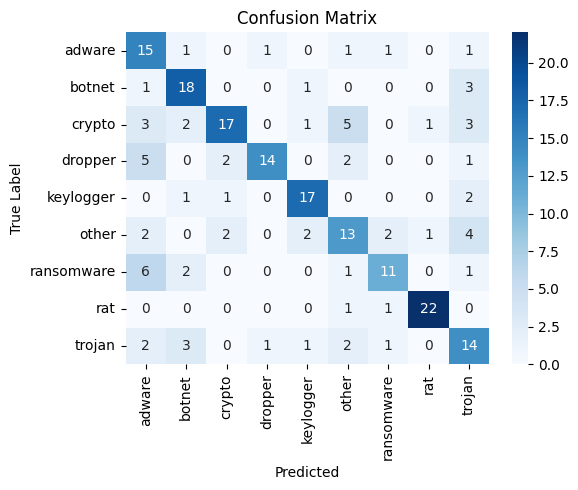


Classification Report:
              precision    recall  f1-score   support

      adware       0.44      0.75      0.56        20
      botnet       0.67      0.78      0.72        23
      crypto       0.77      0.53      0.63        32
     dropper       0.88      0.58      0.70        24
   keylogger       0.77      0.81      0.79        21
       other       0.52      0.50      0.51        26
  ransomware       0.69      0.52      0.59        21
         rat       0.92      0.92      0.92        24
      trojan       0.48      0.58      0.53        24

    accuracy                           0.66       215
   macro avg       0.68      0.66      0.66       215
weighted avg       0.69      0.66      0.66       215



In [35]:
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        seq = batch["sequence"].to(device)
        num = batch["numeric"].to(device)
        lbl = batch["label"].to(device)

        logits = model(seq, num) if hasattr(model, "classifier") else model(seq)

        if cfg.num_classes == 2:
            probs = torch.softmax(logits, dim=1)[:, 1]    # P(class=1)
            preds = (probs > cfg.threshold).long()
        else:
            preds = logits.argmax(dim=1)

        all_preds .extend(preds.cpu().numpy())
        all_labels.extend(lbl.cpu().numpy())

print(f"– Dataset size: {len(test_loader.dataset)}")
print(f"– Collected preds: {len(all_preds)}, labels: {len(all_labels)}")

acc      = accuracy_score(all_labels, all_preds) * 100
f1_macro = f1_score(all_labels, all_preds, average="macro")
print(f"\nTest Accuracy : {acc:.2f}%")
print(f"Test F1-macro : {f1_macro:.4f}")

cm = confusion_matrix(all_labels, all_preds)
names = (le.classes_ if cfg.num_classes > 2 else ["benign","malware"])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=names, yticklabels=names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=names))